In [0]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import scipy.io
import os
from PIL import Image, ImageOps
import numpy as np
import scipy.misc
from six.moves import urllib
from google.colab import files
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

class CNN:
    
    def __init__(self, LEARNING_RATE, BATCH_SIZE, N_EPOCHS, N_CLASSES, CONTENT_WEIGHT, STYLE_WEIGHT, CONTENT_LAYER, STYLE_LAYERS):
        
        self.LEARNING_RATE = LEARNING_RATE
        self.BATCH_SIZE = BATCH_SIZE
        self.SKIP_STEP = SKIP_STEP
        self.N_EPOCHS = N_EPOCHS
        self.N_CLASSES = N_CLASSES
        self.CONTENT_WEIGHT = CONTENT_WEIGHT
        self.STYLE_WEIGHT = STYLE_WEIGHT
        self.CONTENT_LAYER = CONTENT_LAYER
        self.STYLE_LAYERS = STYLE_LAYERS
            
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
     
    def _Weights(self, model_weights, layerNumber, expected_layer_name):
        
        W = model_weights[0][layerNumber][0][0][2][0][0]
        b =  model_weights[0][layerNumber][0][0][2][0][1]
        layer_name = model_weights[0][layerNumber][0][0][0][0]
    
        assert layer_name == expected_layer_name
        
        return W, b.reshape(b.size)
    
    def _AddConv2d(self, prev_layer, model_weights, stride, layer_number, scope_name):
        
        W, b = self._Weights(model_weights, layer_number, scope_name)
        
        with tf.variable_scope(scope_name) as scope:
            kernel = tf.constant(W, name = 'kernel')
            biases = tf.constant(b, name = 'biases')
            conv = tf.nn.conv2d(prev_layer, filter = kernel, strides = stride, padding = 'SAME')
            conv1 = tf.nn.relu(conv + biases, name = scope.name)
        
        return conv1
        
    def _AddAvgPool(self, prev_layer, ksize, strides, scope_name):
        
        with tf.variable_scope(scope_name) as scope:
            pool = tf.nn.avg_pool(prev_layer, ksize = ksize, strides = strides,padding='SAME')
        
        return pool
    
    def _CreateContentLoss(self, p, f):
                
        return tf.reduce_sum((f - p) ** 2) / (4.0 * p.size)
    
    def _GramMatrix(self, F, N, M):

        F = tf.reshape(F, (M, N))
        
        return tf.matmul(tf.transpose(F), F)
    
    def _SingleStyleLoss(self, a, g):

        N = a.shape[3] 
        M = a.shape[1] * a.shape[2] 
        A = self._GramMatrix(a, N, M)
        G = self._GramMatrix(g, N, M)
        
        return tf.reduce_sum((G - A) ** 2 / ((2 * N * M) ** 2))
    
    def _CreateStyleLoss(self, A):

        n_layers = len(self.STYLE_LAYERS)
        E = [self._SingleStyleLoss(A[i], self.graph[self.STYLE_LAYERS[i]]) for i in range(n_layers)]

        return sum([W[i] * E[i] for i in range(n_layers)])
    
    def _CreateLosses(self, input_image, content_image, style_image):
        
        with tf.variable_scope('loss') as scope:
            with tf.Session() as sess:
                sess.run(input_image.assign(content_image))
                p = sess.run(self.graph[self.CONTENT_LAYER])
            content_loss = self._CreateContentLoss(p, self.graph[self.CONTENT_LAYER])
    
            with tf.Session() as sess:
                sess.run(input_image.assign(style_image))
                A = sess.run([self.graph[layer_name] for layer_name in self.STYLE_LAYERS])                              
            style_loss = self._CreateStyleLoss(A)
    
            total_loss = self.CONTENT_WEIGHT * content_loss + self.STYLE_WEIGHT * style_loss

        return content_loss, style_loss, total_loss
    
    def _CreateOptimizer(self,loss):
        
        optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).minimize(loss, global_step=self.global_step)
        
        return optimizer
    
    def _CreateSummary(self):

        with tf.name_scope('summaries'):
            tf.summary.scalar('content loss', self.graph['content_loss'])
            tf.summary.scalar('style loss', self.graph['style_loss'])
            tf.summary.scalar('total loss', self.graph['total_loss'])
            tf.summary.histogram('histogram content loss', self.graph['content_loss'])
            tf.summary.histogram('histogram style loss', self.graph['style_loss'])
            tf.summary.histogram('histogram total loss', self.graph['total_loss'])
            return tf.summary.merge_all()
        
    def _BuildGraph(self, model_weights, input_image, content_image, style_image):
        
        images = input_image
        
        self.graph = {}
        
        # define architecture here:
        
        # convoltuion block 1
        self.graph['conv1_1']   = self._AddConv2d(images, model_weights, [1, 1, 1, 1], 0, 'conv1_1')
        self.graph['conv1_2']   = self._AddConv2d(self.graph['conv1_1'], model_weights, [1, 1, 1, 1], 2, 'conv1_2')
        
        self.graph['pool1']   = self._AddAvgPool(self.graph['conv1_2'], [1, 2, 2, 1], [1, 2, 2, 1], 'pool1')
        
        # convolution block 2
        self.graph['conv2_1']   = self._AddConv2d(self.graph['pool1'], model_weights, [1, 1, 1, 1], 5, 'conv2_1')
        self.graph['conv2_2']   = self._AddConv2d(self.graph['conv2_1'], model_weights, [1, 1, 1, 1], 7, 'conv2_2')
        
        self.graph['pool2']   = self._AddAvgPool(self.graph['conv2_2'], [1, 2, 2, 1], [1, 2, 2, 1], 'pool2')
        
        # convolution block 3
        self.graph['conv3_1']   = self._AddConv2d(self.graph['pool2'], model_weights, [1, 1, 1, 1], 10, 'conv3_1')
        self.graph['conv3_2']   = self._AddConv2d(self.graph['conv3_1'], model_weights, [1, 1, 1, 1], 12, 'conv3_2')
        self.graph['conv3_3']   = self._AddConv2d(self.graph['conv3_2'], model_weights, [1, 1, 1, 1], 14, 'conv3_3')
        self.graph['conv3_4']   = self._AddConv2d(self.graph['conv3_3'], model_weights, [1, 1, 1, 1], 16, 'conv3_4')
        
        self.graph['pool3']   = self._AddAvgPool(self.graph['conv3_4'], [1, 2, 2, 1], [1, 2, 2, 1], 'pool3')
        
        # convolution block 4
        self.graph['conv4_1']   = self._AddConv2d(self.graph['pool3'], model_weights, [1, 1, 1, 1], 19, 'conv4_1')
        self.graph['conv4_2']   = self._AddConv2d(self.graph['conv4_1'], model_weights, [1, 1, 1, 1], 21, 'conv4_2')
        self.graph['conv4_3']   = self._AddConv2d(self.graph['conv4_2'], model_weights, [1, 1, 1, 1], 23, 'conv4_3')
        self.graph['conv4_4']   = self._AddConv2d(self.graph['conv4_3'], model_weights, [1, 1, 1, 1], 25, 'conv4_4')
        
        self.graph['pool4']   = self._AddAvgPool(self.graph['conv4_4'], [1, 2, 2, 1], [1, 2, 2, 1], 'pool4')
            
        # convolution block 5
        self.graph['conv5_1']   = self._AddConv2d(self.graph['pool4'], model_weights, [1, 1, 1, 1], 28, 'conv5_1')
        self.graph['conv5_2']   = self._AddConv2d(self.graph['conv5_1'], model_weights, [1, 1, 1, 1], 30, 'conv5_2')
        self.graph['conv5_3']   = self._AddConv2d(self.graph['conv5_2'], model_weights, [1, 1, 1, 1], 32, 'conv5_3')
        self.graph['conv5_4']   = self._AddConv2d(self.graph['conv5_3'], model_weights, [1, 1, 1, 1], 34, 'conv5_4')
        
        self.graph['pool5']   = self._AddAvgPool(self.graph['conv5_4'], [1, 2, 2, 1], [1, 2, 2, 1], 'pool5')
        
        ################################
        
        self.graph['content_loss'], self.graph['style_loss'], self.graph['total_loss'] = self._CreateLosses(input_image, content_image, style_image)
        
        # create optimizer
        self.graph['optimizer'] = self._CreateOptimizer(self.graph['total_loss'])
        
        # create summary
        self.graph['summary_op'] = self._CreateSummary()
    
def train(model, generated_image, initial_image):

    skip_step = 1
    with tf.Session() as sess:
        saver = tf.train.Saver()

        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('graphs', sess.graph)
        
        ###############################
        sess.run(generated_image.assign(initial_image))
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        initial_step = model.global_step.eval()
        
        start_time = time.time()
        for index in range(initial_step, N_EPOCHS):
            if index >= 5 and index < 20:
                skip_step = 10
            elif index >= 20:
                skip_step = 20
            
            sess.run(model.graph['optimizer'])
            if (index + 1) % skip_step == 0:
                ###############################
                gen_image, total_loss, summary = sess.run([generated_image, model.graph['total_loss'],model.graph['summary_op']])

                ###############################
                gen_image = gen_image + MEAN_PIXELS
                writer.add_summary(summary, global_step=index)
                print('Step {}\n   Sum: {:5.1f}'.format(index + 1, np.sum(gen_image)))
                print('   Loss: {:5.1f}'.format(total_loss))
                print('   Time: {}'.format(time.time() - start_time))
                start_time = time.time()

                filename = 'outputs/%d.png' % (index)
                save_image(filename, gen_image)

                if (index + 1) % 20 == 0:
                    saver.save(sess, 'checkpoints/style_transfer', index)



# Some utility functions to facilitate input and output
                    
def get_resized_image(img_path, height, width, save=True):
    
    image = Image.open(img_path)
    image = ImageOps.fit(image, (width, height), Image.ANTIALIAS)
    if save:
        image_dirs = img_path.split('/')
        image_dirs[-1] = 'resized_' + image_dirs[-1]
        out_path = '/'.join(image_dirs)
        if not os.path.exists(out_path):
            image.save(out_path)
    image = np.asarray(image, np.float32)
    
    return np.expand_dims(image, 0)

def generate_noise_image(content_image, height, width, noise_ratio=0.6):
    
    noise_image = np.random.uniform(-20, 20, (1, height, width, 3)).astype(np.float32)
    
    return noise_image * noise_ratio + content_image * (1 - noise_ratio)

def save_image(path, image):

    image = image[0] # the image
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [8]:
if __name__ == '__main__':
    
    ##########################################################################################
    LEARNING_RATE = 2.0
    BATCH_SIZE = 128
    SKIP_STEP = 10
    DROPOUT = 0.5
    N_EPOCHS = 300
    N_CLASSES = 10
    
    # upload images
    
    files.upload()
    
    STYLE = 'starry_night'
    CONTENT = 'cyber_greens'
    STYLE_IMAGE = STYLE + '.jpg'
    CONTENT_IMAGE = CONTENT + '.jpg'
    IMAGE_HEIGHT = 250
    IMAGE_WIDTH = 333
    NOISE_RATIO = 0.6
    
    CONTENT_WEIGHT = 0.01
    STYLE_WEIGHT = 1
    
    VGG_DOWNLOAD_LINK = 'http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat'
    VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'
    
    urllib.request.urlretrieve(VGG_DOWNLOAD_LINK, VGG_MODEL)
    
    STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
    W = [0.5, 1.0, 1.5, 3.0, 4.0]
    
    CONTENT_LAYER = 'conv4_2'
    
    MEAN_PIXELS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
    
    ##########################################################################################
    
    with tf.variable_scope('input') as scope:

        input_image = tf.Variable(np.zeros([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3]), dtype=tf.float32)
        
        
    # load model weights
    vgg = scipy.io.loadmat('imagenet-vgg-verydeep-19.mat')
    
    # make directory to save checkpoints and output files
    os.mkdir('checkpoints')
    os.mkdir('outputs')
    
    # bring in the image
    content_image = get_resized_image(CONTENT_IMAGE, IMAGE_HEIGHT, IMAGE_WIDTH)
    content_image = content_image - MEAN_PIXELS
    style_image = get_resized_image(STYLE_IMAGE, IMAGE_HEIGHT, IMAGE_WIDTH)
    style_image = style_image - MEAN_PIXELS
    
    # generate noise image
    initial_image = generate_noise_image(content_image, IMAGE_HEIGHT, IMAGE_WIDTH, NOISE_RATIO)
    
    # create CNN obkject
    model = CNN( LEARNING_RATE, BATCH_SIZE, N_EPOCHS, N_CLASSES, CONTENT_WEIGHT, STYLE_WEIGHT, CONTENT_LAYER, STYLE_LAYERS)
    
    # build graph
    model._BuildGraph(vgg['layers'], input_image, content_image, style_image)
   
    # train model and see the magic
    train(model, input_image, initial_image)

Saving cyber_greens.jpg to cyber_greens.jpg
Saving starry_night.jpg to starry_night.jpg
INFO:tensorflow:Summary name content loss is illegal; using content_loss instead.
INFO:tensorflow:Summary name style loss is illegal; using style_loss instead.
INFO:tensorflow:Summary name total loss is illegal; using total_loss instead.
INFO:tensorflow:Summary name histogram content loss is illegal; using histogram_content_loss instead.
INFO:tensorflow:Summary name histogram style loss is illegal; using histogram_style_loss instead.
INFO:tensorflow:Summary name histogram total loss is illegal; using histogram_total_loss instead.
Step 1
   Sum: 30968152.4
   Loss: 1481088384.0
   Time: 4.7996416091918945
Step 2
   Sum: 30972041.2
   Loss: 1181619072.0
   Time: 0.17590689659118652


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:244: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Step 3
   Sum: 30976155.0
   Loss: 943429760.0
   Time: 0.18421125411987305
Step 4
   Sum: 30980650.6
   Loss: 755250368.0
   Time: 0.156782865524292
Step 5
   Sum: 30985386.1
   Loss: 609353216.0
   Time: 0.15394067764282227
Step 10
   Sum: 31004915.6
   Loss: 332914432.0
   Time: 0.5159902572631836
Step 20
   Sum: 30990246.9
   Loss: 146124832.0
   Time: 0.9708812236785889
Step 40
   Sum: 30821451.5
   Loss: 57810636.0
   Time: 3.409106492996216
Step 60
   Sum: 30654391.2
   Loss: 34279392.0
   Time: 3.042315721511841
Step 80
   Sum: 30549203.6
   Loss: 24844846.0
   Time: 3.7418646812438965
Step 100
   Sum: 30472311.0
   Loss: 19704542.0
   Time: 3.1372365951538086
Step 120
   Sum: 30405405.2
   Loss: 16405355.0
   Time: 3.13415789604187
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Step 140
   Sum: 30344874.9
   Loss: 14068110.0
   Time: 3.1683337688446045
Step 160
   Sum: 30288891.9
   Loss: 12321567.0
   Time: 3.198730230331421
Step 180
   Su

In [9]:
!ls

checkpoints	  imagenet-vgg-verydeep-19.mat	resized_starry_night.jpg
cyber_greens.jpg  outputs			starry_night.jpg
graphs		  resized_cyber_greens.jpg


In [10]:
!ls outputs/

0.png	 159.png  19.png   239.png  299.png  3.png   79.png
119.png  179.png  1.png    259.png  2.png    4.png   99.png
139.png  199.png  219.png  279.png  39.png   59.png  9.png


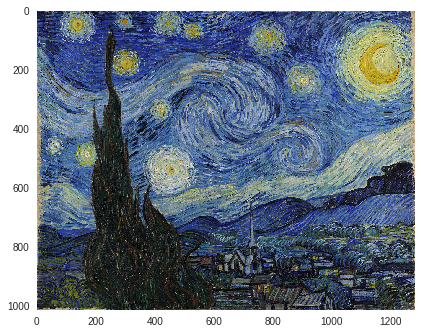

In [15]:
style_image = Image.open('starry_night.jpg')
plt.imshow(style_image)

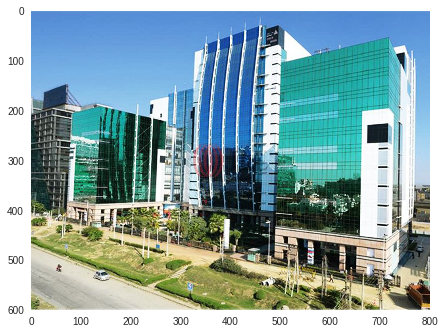

In [16]:
content_image = Image.open('cyber_greens.jpg')
plt.imshow(content_image)

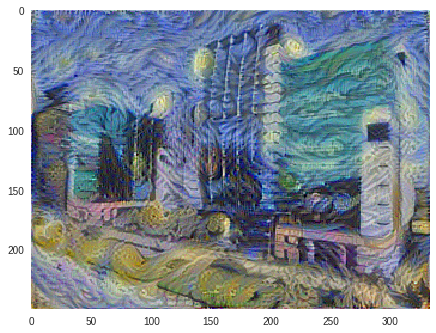

In [17]:
NeuralStyleTransfered_Image = Image.open('outputs/299.png')
plt.imshow(NeuralStyleTransfered_Image)